In [1]:
import pandas as pd

In [2]:
import sklearn
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer,
    make_column_selector,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
sklearn.set_config(display="diagram")

In [5]:
df = pd.read_csv("titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
5,0,3,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [14]:
def extract_title(series):
    return series.str.split("").str[1].str.split().str[0].to_frame()


title_extractor = FunctionTransformer(extract_title)

In [15]:
def extract_deck(series):
    return series.str[0].to_frame()


deck_extractor = FunctionTransformer(extract_deck)

In [16]:
deck_pipeline = make_pipeline(
    deck_extractor,
    SimpleImputer(strategy="constant", fill_value="U"),
    OneHotEncoder(handle_unknown="ignore"),
)

In [17]:
numerical_pipeline = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=8))

In [18]:
ct = make_column_transformer(
    (
        make_pipeline(title_extractor, OneHotEncoder(handle_unknown="ignore")),
        "Name",
    ),  # No square brackets around ["Name"]
    (deck_pipeline, "Cabin"),
    (
        OneHotEncoder(handle_unknown="ignore"),
        ["Sex"],
    ),  # Square brackets around ["Sex"]!
    (numerical_pipeline, make_column_selector(dtype_include="number")),
)

In [19]:
clf = Pipeline(
    [
        ("preprocessing", ct),
        ("regression", LogisticRegression()),
    ]
)
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_title at 0x7fe8050de8b0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Name'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_dec...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Cabin'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer(n_neighbors=8))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe804f0c7c0>)])),
                ('regression', LogisticRegression())])

In [20]:
clf.fit(X, y)
clf.predict(X)

scores = cross_val_score(clf, X, y)
scores

array([0.79329609, 0.80337079, 0.78089888, 0.78651685, 0.80898876])

In [21]:
scores.mean()

0.7946142740568704

In [22]:
param_grid = [
    {"preprocessing__pipeline-3__knnimputer__n_neighbors": range(3, 10)},
    {
        "regression": [RandomForestClassifier()],
        "regression__n_estimators": range(10, 100, 5),
    },
]

In [23]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)

In [24]:
gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function extract_title at 0x7fe8050de8b0>)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         'Name'),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(fu...
                                                                                         ('knnimputer',
                                                                                          KNNImputer(n_neighbors=8))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe804f0c7c0>)])),
                                       ('regression', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'preprocessing__pipeline-3__knnimputer__n_neighbors': range(3, 10)},
                         {'regression': [RandomForestClassifier(n_estimators=45)],
                          'regression__n_estimators': range(10, 100, 5)}])

In [25]:
gs.best_params_

{'regression': RandomForestClassifier(n_estimators=45),
 'regression__n_estimators': 45}

In [26]:
gs.best_score_

0.8215931203314291

In [27]:
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__pipeline-3__knnimputer__n_neighbors,param_regression,param_regression__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.178565,0.003190,0.033380,0.005019,NaN,RandomForestClassifier(n_estimators=45),45,{'regression': RandomForestClassifier(n_estima...,0.782123,0.803371,0.887640,0.775281,0.859551,0.821593,0.044357,1
16,0.203827,0.008861,0.028874,0.003711,NaN,RandomForestClassifier(n_estimators=45),55,{'regression': RandomForestClassifier(n_estima...,0.787709,0.803371,0.876404,0.775281,0.853933,0.819340,0.039114,2
11,0.115419,0.002554,0.024563,0.000734,NaN,RandomForestClassifier(n_estimators=45),30,{'regression': RandomForestClassifier(n_estima...,0.782123,0.808989,0.882022,0.764045,0.853933,0.818222,0.043976,3
12,0.128420,0.002540,0.025684,0.003806,NaN,RandomForestClassifier(n_estimators=45),35,{'regression': RandomForestClassifier(n_estima...,0.776536,0.803371,0.865169,0.780899,0.859551,0.817105,0.038097,4
13,0.152573,0.006137,0.031253,0.002688,NaN,RandomForestClassifier(n_estimators=45),40,{'regression': RandomForestClassifier(n_estima...,0.782123,0.803371,0.882022,0.752809,0.865169,0.817099,0.049134,5


In [28]:
n_neighbors_results = (
    results[
        [
            "param_preprocessing__pipeline-3__knnimputer__n_neighbors",
            "mean_test_score",
            "std_test_score",
        ]
    ]
    .rename(
        columns={
            "param_preprocessing__pipeline-3__knnimputer__n_neighbors": "n_neighbors"
        }
    )
    .dropna()
)

In [29]:
n_neighbors_results

,n_neighbors,mean_test_score,std_test_score
6,9,0.794614,0.010380
5,8,0.794614,0.010380
3,6,0.792367,0.012819
2,5,0.792367,0.012819
1,4,0.792367,0.012819
4,7,0.791243,0.012027
0,3,0.790126,0.011508


<AxesSubplot:xlabel='n_neighbors'>

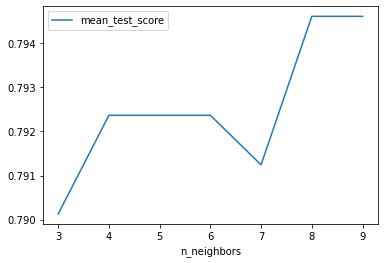

In [30]:
n_neighbors_results.sort_values("n_neighbors").plot(
    x="n_neighbors", y="mean_test_score"
)

In [31]:
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_title at 0x7fe8050de8b0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Name'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_dec...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Cabin'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer(n_neighbors=8))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe804f0c7c0>)])),
                ('regression', LogisticRegression())])

In [32]:
from sklearn.model_selection import learning_curve

In [35]:
train_sizes, train_scores, test_scores = learning_curve(clf, X, y)

In [36]:
train_scores

array([[0.84507042, 0.90140845, 0.90140845, 0.90140845, 0.90140845],
       [0.82683983, 0.83116883, 0.83116883, 0.83116883, 0.83116883],
       [0.81329923, 0.81585678, 0.82352941, 0.82608696, 0.82608696],
       [0.80399274, 0.81125227, 0.82395644, 0.81306715, 0.81488203],
       [0.80898876, 0.80477528, 0.81179775, 0.81179775, 0.82022472]])

In [51]:
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean= test_scores.mean(axis=1)

train_scores_std = train_scores.std(axis=1)
test_scores_std=test_scores.std(axis=1)

In [52]:
import matplotlib.pyplot as plt

In [53]:
import seaborn as sns 
sns.set()

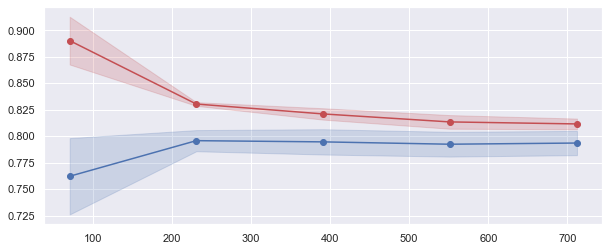

In [56]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(train_sizes, train_scores_mean, "o-", color = "r", label = "training scores")#;
ax.plot(train_sizes, test_scores_mean, "o-", color = "b");

ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std, 
    train_scores_mean + train_scores_std,
    color = "r", 
    alpha = 0.2
)

ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std, 
    test_scores_mean + test_scores_std,
    color = "b", 
    alpha = 0.2
)
#semi column to remove the explaination on top of the graph

In [58]:
tips = sns.load_dataset("tips")

In [64]:
tips["small_table"] = (tips["size"]<=2)

array([[<AxesSubplot:title={'center':'day = Thur | smoker = Yes'}, ylabel='tip'>,
        <AxesSubplot:title={'center':'day = Thur | smoker = No'}>],
       [<AxesSubplot:title={'center':'day = Fri | smoker = Yes'}, ylabel='tip'>,
        <AxesSubplot:title={'center':'day = Fri | smoker = No'}>],
       [<AxesSubplot:title={'center':'day = Sat | smoker = Yes'}, ylabel='tip'>,
        <AxesSubplot:title={'center':'day = Sat | smoker = No'}>],
       [<AxesSubplot:title={'center':'day = Sun | smoker = Yes'}, xlabel='total_bill', ylabel='tip'>,
        <AxesSubplot:title={'center':'day = Sun | smoker = No'}, xlabel='total_bill'>]],
      dtype=object)

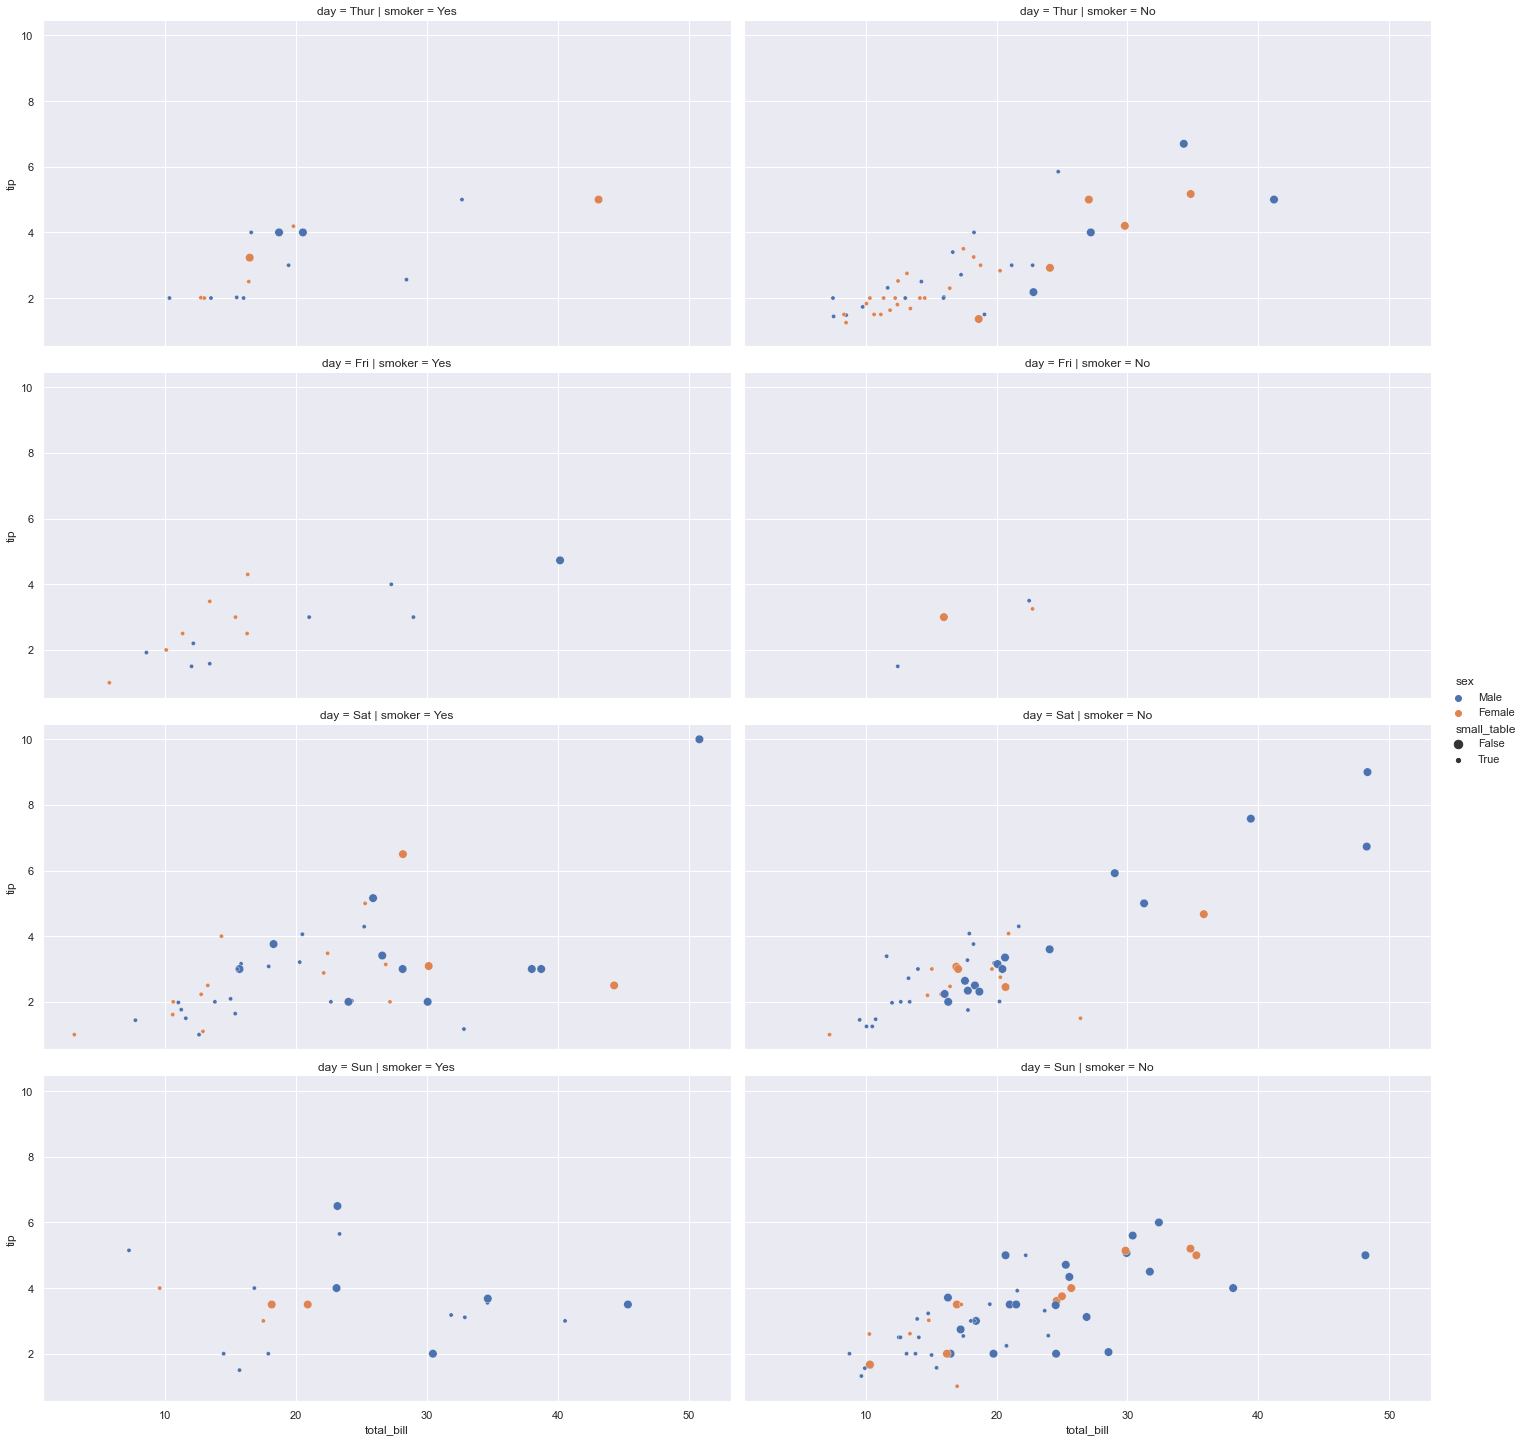

In [72]:
grid = sns.relplot(
    data=tips,
    x = "total_bill",
    y= "tip", 
    hue = "sex", 
    size = "small_table", 
    col = "smoker",
    row = "day", 
    aspect =2,
)

grid.axes